# Personal Finance Exploratory Data Analysis

The goal of this notebook is to explore the data extracted from Reddit's Personal Finance subreddit, including information such as the title of the submissions, the date of submission, the flair (topic), etc. Using Natural Language Processing tools and data visualization, we aim to learn any obvious and underlying trends from the submission information. In particular, we want to observe whether the data can tell us any interesting details about the users who submitted the posts such as what financial issues they may be facing. 

In [2]:
# Begin by importing the relevant libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk import word_tokenize
from nltk import PorterStemmer
import string
import re
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import spacy
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from pf import *

C:\Users\joshu\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# Import the dataframe using the pf module
df.head()

,title,date,time,upvotes,id,topic,clean_title,tokenized_title,lemmatized_title,named_entities,entity_labels
0,Ways to make extra side money?,2018-09-19,12:57 PM,1,9h6whn,unknown,ways make extra side money,"[ways, make, extra, side, money]","[way, make, extra, side, money]",[],[]
1,"(Year UPDATE) Legally blind, going homeless, h...",2018-09-19,12:56 AM,16,9h29g7,Other,year update legally blind going homeless one i...,"[year, update, legally, blind, going, homeless...","[year, update, legally, blind, go, homeless, o...",[1.4k a month],[DATE]
2,"19, being kicked out",2018-09-19,12:55 PM,2,9h6vyv,Other,kicked,[kicked],[kicked],[19],[CARDINAL]
3,Online Savings Account?,2018-09-19,12:54 PM,1,9h6vs4,Saving,online savings account,"[online, savings, account]","[online, saving, account]",[Online Savings Account],[ORG]
4,Tools for Managing Incomes and Expenses,2018-09-19,12:52 PM,0,9h6v48,Other,tools managing incomes expenses,"[tools, managing, incomes, expenses]","[tool, manage, income, expense]",[],[]


In [4]:
# Top 10 most popular topics (flairs)
df.topic.value_counts()[0:10]

Debt          1256
Other         1205
Credit        1048
Investing      859
Retirement     824
Employment     724
Housing        709
unknown        653
Auto           560
Planning       526
Name: topic, dtype: int64

### Which are the most popular topics?

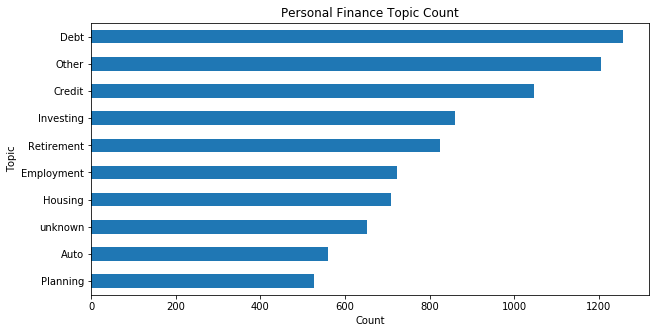

In [5]:
plt.figure(figsize = (10,5))
df.topic.value_counts()[0:10][::-1].plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.title('Personal Finance Topic Count')
plt.show()

- Debt is the most popular topic in the personal finance subreddit, followed by Other and Credit. This indicates that debt is a major concern for many of the redditors (users) and they make submissions in order to seek advice.

- Other would include topics that don't match the default topics. With more data, it could be possible that Other is the most popular topic instead of Debt.

- Investment and Retirement are also similar in their counts while also being very similar in their functions.

- Let's look at the top 10 most popular submissions by sorting them by the number of upvotes.

In [6]:
# Top 10 most popular headlines
[title for title in df.sort_values(by='upvotes', ascending=False)['title'].values[:10]]

["IRS will allow employers to match their employees' student loan repayments",
 'Your amazon store card is probably scamming you',
 'So I fell for a scam yesterday and it still angers me.',
 'Wife passed away. I would truly appreciate some help figuring out where I stand.',
 'Bought a car today. Transmission went out 60 miles from the car lot and everyone had gone home for the day. Is there any chance I can get a refund?',
 'My girlfriend is being offered a too good to be true job with little to no personal history with employer.',
 'Do I need a credit card? I have been strongly advised against it by my parents who say its a scam and should be illegal but everything I look at says that no credit is just as bad if not worse than low credit. What should I do?',
 '[US] Paypal account balance is -$2000. What can they do?',
 'Why You Might Consider A Trade Over College (One Real-World Perspective)',
 '"Hidden" costs of buying a home and how to prepare for them.']

- There are a variety of different subjects in the top 10 most popular posts, ranging from scams to dealing with the loss of a family member.

- However, 3 of the top 10 include the word "scam", showing that this may be a popular subject in /r/personalfinance and could happen often. This could be a common issue among many people living in the US.

- While some posts are seeking advice, others provide advice such as '"Hidden" costs of buying a home and how to prepare for them.'

- Next let's use the tokenized data and extract key words from the 20 most popular submissions. 

In [7]:
df['lemmatized_title'].head()

0                      [way, make, extra, side, money]
1    [year, update, legally, blind, go, homeless, o...
2                                             [kicked]
3                            [online, saving, account]
4                      [tool, manage, income, expense]
Name: lemmatized_title, dtype: object

In [8]:
# Create a pandas series of the tokens by count
all_words = pd.Series(np.concatenate(df['lemmatized_title'])).value_counts()

In [9]:
# Add 'k' to the list of stopwords since it seems to occur often
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords = set(stopwords)

In [10]:
all_words = all_words[[word not in stopwords for word in all_words.index]]
all_words = all_words[[word not in string.punctuation for word in all_words.index]]
all_words = all_words[[word not in string.digits for word in all_words.index]]
all_words = all_words[["'" not in word for word in all_words.index]]
all_words = all_words[[word for word in all_words.index if len(word)>2]]

In [11]:
all_words[:10].index

Index(['credit', 'pay', 'loan', 'get', 'card', 'need', 'debt', 'car', 'help',
       'advice'],
      dtype='object')

### Which are the most frequent tokens?

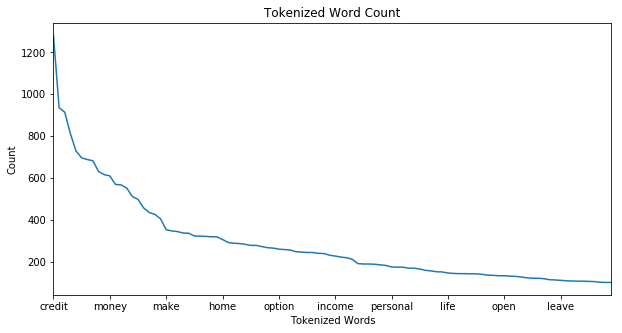

In [12]:
# Create a list of words evenly spread out by 10 in the top 100.
x = np.arange(0,100,10)
ten_words_list = []
for a in x:
    ten_words_list.append(all_words.index[a])

# Plot the words.
plt.figure(figsize = (10,5))
all_words[:100].plot()
plt.xticks(np.arange(0,100, 10), ten_words_list)
plt.xlabel('Tokenized Words')
plt.ylabel('Count')
plt.title('Tokenized Word Count')
plt.show()

### How does the popularity of posts change over time?

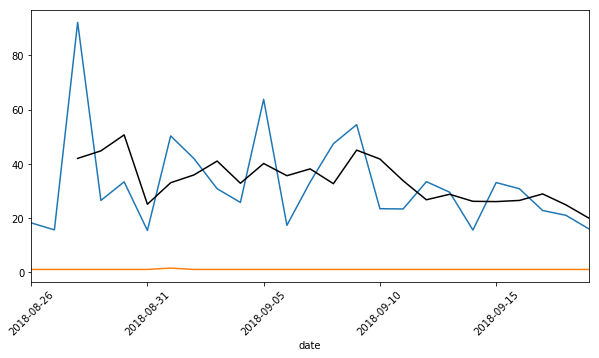

In [13]:
plt.figure(figsize=(10,5))
df.groupby('date')['upvotes'].mean().plot()
df.groupby('date')['upvotes'].median().plot()
df.groupby('date')['upvotes'].mean().rolling(window=3).mean().plot(color='black')
plt.xticks(rotation=45)
plt.show()

### What does the distribution of the title length look like?

In [13]:
# Create new column for text length
df['text_len'] = df['title'].apply(lambda x: len(x) - x.count(' '))

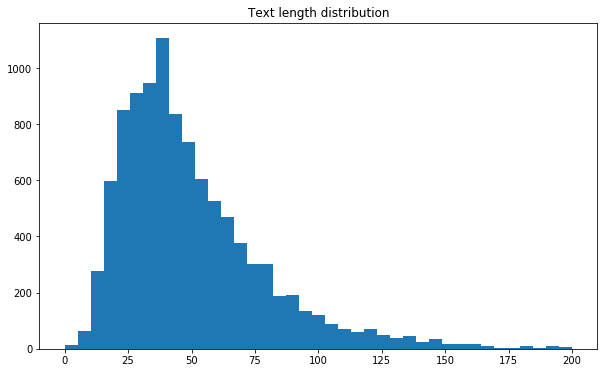

In [14]:
bins = np.linspace(0,200,40)
plt.figure(figsize=(10,6))
plt.hist(df['text_len'], bins)
plt.title('Text length distribution')
plt.show()

- Next, let's observe the distribution of the title lengths according to topic.

In [15]:
unique_topics = [x for x in df['topic'].unique() if x == x]

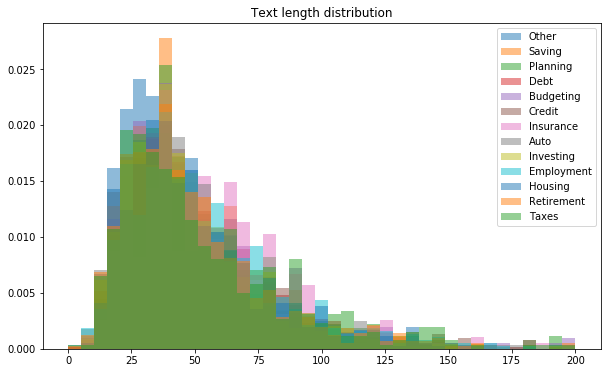

In [16]:
bins = np.linspace(0,200,40)

plt.figure(figsize=(10,6))
for topic in unique_topics:
    plt.hist(df[df['topic']==topic]['text_len'], bins, alpha = 0.5, density = True, label = topic)
plt.legend()
plt.title('Text length distribution')
plt.show()

### Most popular tokens by POS (Part-of-Speech) Tagging

In [17]:
# # Load the dictionary
# nlp = spacy.load('en_core_web_sm')
# doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')

# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#           token.shape_, token.is_alpha, token.is_stop)

In [17]:
# Create function that returns the POS tag for each token 
def pos_tag(token_list):
    pos_list = [x.tag_ for x in token_list]
    return pos_list

df['pos_tag'] = df['tokenized_title'].apply(lambda x: pos_tag(x))

In [18]:
# Create function that returns the token text for only singular/plural nouns
def topicify(df):
    tags = df['pos_tag']
    tokens = df['tokenized_title1']
    return [token.text for (tag, token) in zip(tags, tokens) if tag in ['NN', 'NNS']]

In [19]:
# Create new column 'gen_topics' for noun-based tokens
df['gen_topics'] = df.apply(topicify, axis = 'columns')

In [20]:
df['gen_topics'].head()

0           [ways, side, money]
1    [year, update, job, month]
2                            []
3            [savings, account]
4    [tools, incomes, expenses]
Name: gen_topics, dtype: object

In [21]:
# Create a pandas series sorted by value count in descending order
topic_counts = pd.Series(np.concatenate(df['gen_topics'].values)).value_counts()

In [38]:
topic_counts.head(10)

credit     1262
car         667
debt        654
card        618
advice      611
loan        609
money       609
student     502
job         497
account     357
dtype: int64

Let's now take a look at the most popular tokens by count.

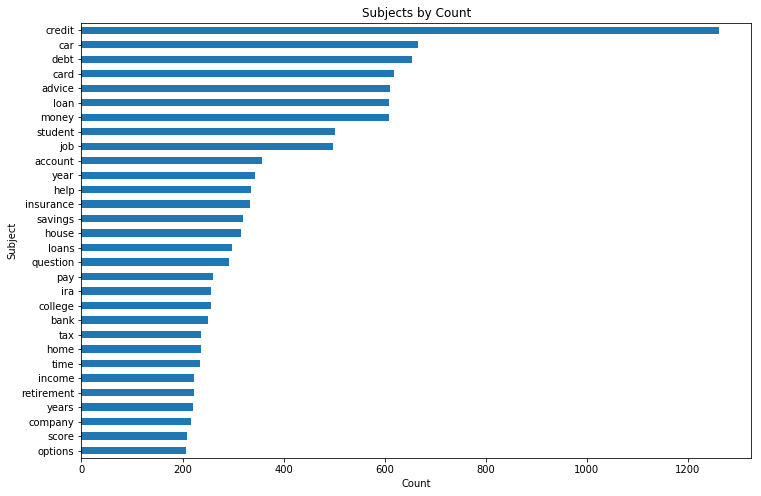

In [23]:
plt.figure(figsize=(12,8))
topic_counts.head(30)[::-1].plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.title('Subjects by Count')
plt.show()

### Visualizing the dependency schemes

A dependency, in the linguistic context, is a grammatical class that represents the structural relationship between words in a sentence. Here is a list of the different dependency types: https://emorynlp.github.io/nlp4j/components/dependency-parsing.html 

Let's take a look at an example of dependency schemes using the displacy feature.

In [24]:
from spacy import displacy
nlp = spacy.load('en')

# "IRS will allow employers to match their employees' student loan repayments"
title_ex = df.sort_values('upvotes', ascending = False)['title'].values[0]
doc = nlp(title_ex)
displacy.render(doc, style='dep',jupyter=True,options={'distance': 100})

In this case, the verb 'allow' could potentially be the root of the sentence (which acts as the foundation of the sentence structure).

This doesn't actually add any value to the model but it looks very interesting and overall a neat feature if you want to dive deeper into the semantics and grammatical structure of the sentences.

### What are the most common named entities?

Just to recap, named entities are real-world objects that have a name, such as a person, country, or company. spaCy is able to recognize different types of named entities in a document and can return features such as the label (ex. ORG - organization, GPE - geopolitical entity).

By observing the named entities for our dataset, we can look for key patterns such as any companies or products that come up often in the posts.

In [26]:
from collections import Counter
NE_counter = np.concatenate(df['named_entities'])
word_counter = Counter(NE_counter)
word_counter.most_common(10)

[('401k', 247),
 ('first', 193),
 ('US', 145),
 ('Roth IRA', 95),
 ('UK', 71),
 ('401', 63),
 ('one', 61),
 ('Roth', 58),
 ('monthly', 52),
 ('HSA', 45)]

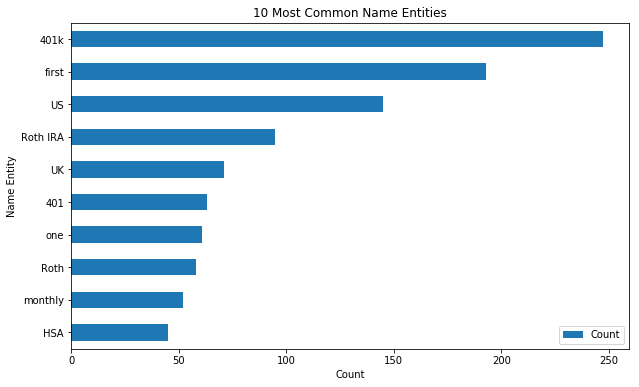

In [27]:
word_counter = Counter(NE_counter)
lst = word_counter.most_common(10)[::-1]
word_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
word_df.plot(kind = 'barh',x='Word',y='Count',figsize = (10,6))
plt.title('10 Most Common Name Entities')
plt.xlabel('Count')
plt.ylabel('Name Entity')
plt.show()

In [ ]:
NE_counter = np.concatenate(df['named_entities'])
word_counter = Counter(NE_counter)
word_counter.most_common(10)

In [ ]:
word_counter = Counter(NE_counter)
lst = word_counter.most_common(10)[::-1]
word_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
word_df.plot(kind = 'barh',x='Word',y='Count',figsize = (10,6))
plt.title('10 Most Common Name Entities')
plt.xlabel('Count')
plt.ylabel('Name Entity')
plt.show()

### Sentiment analysis

Let's try doing sentiment analysis using the SentimentIntensityAnalyzer function.

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [34]:
top_1000 = topic_counts.sort_values(ascending=False).head(1000)
top_1000_sentiments = [sid.polarity_scores(w)['compound'] for w in top_1000.index]

In [35]:
tmp = pd.DataFrame(top_1000).assign(sentiment=top_1000_sentiments)

Let's plot the most popular positive and negative tokens.

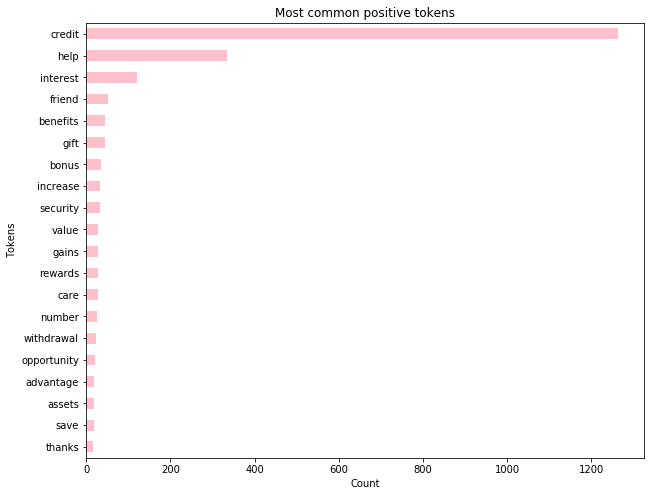

In [36]:
plt.figure(figsize=(10,8))
tmp[tmp.sentiment>0].head(20)[0][::-1].plot(kind='barh', color='pink')
plt.title('Most common positive tokens')
plt.xlabel('Count')
plt.ylabel('Tokens')
plt.show()

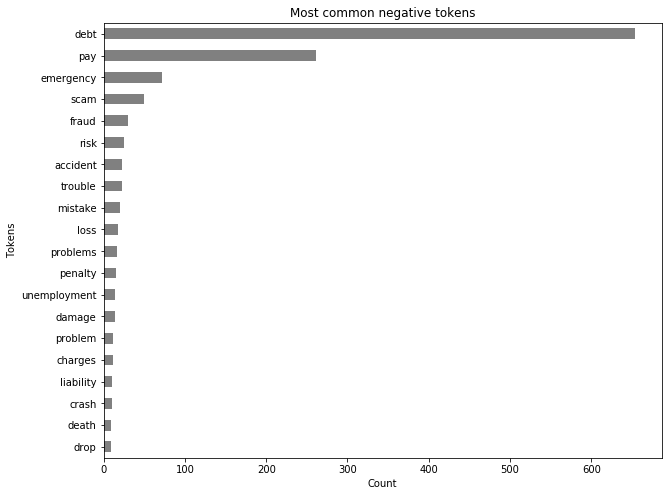

In [37]:
plt.figure(figsize=(10,8))
tmp[tmp.sentiment<0].head(20)[0][::-1].plot(kind='barh', color='grey')
plt.title('Most common negative tokens')
plt.xlabel('Count')
plt.ylabel('Tokens')
plt.show()
plt.show()